In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.4 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import textwrap

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [ ]:
clf = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
clf("This is a great movie", candidate_labels=["positive", "negative"])

{'sequence': 'This is a great movie',
 'labels': ['positive', 'negative'],
 'scores': [0.9969461560249329, 0.0030538293067365885]}

In [ ]:
text = "Due to the presence of isoforms of its components, there are 12 " + \
  "versions of AMPK in mammals, each of which can have different tissue " + \
  "localizations, and different functions under different conditions. " + \
  "AMPK is regulated allosterically and by post-translational " + \
  "modification, which work together."
clf(text, candidate_labels=["biology", "math", "geology"])

{'sequence': 'Due to the presence of isoforms of its components, there are 12 versions of AMPK in mammals, each of which can have different tissue localizations, and different functions under different conditions. AMPK is regulated allosterically and by post-translational modification, which work together.',
 'labels': ['biology', 'math', 'geology'],
 'scores': [0.8908604383468628, 0.06606573611497879, 0.0430738590657711]}

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2023-06-20 15:29:34--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  --.-KB/s    in 0.09s   

2023-06-20 15:29:35 (54.1 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [ ]:
df = pd.read_csv('bbc_text_cls.csv')

In [ ]:
len(df)

2225

In [ ]:
df.sample(frac=1).head()

,text,labels
1646,Stevens named in England line-up\n\nEngland ha...,sport
1937,Games maker fights for survival\n\nOne of Brit...,tech
1844,Britons fed up with net service\n\nA survey co...,tech
628,Ring of Fire hit co-writer dies\n\nMerle Kilgo...,entertainment
630,Belle named 'best Scottish band'\n\nBelle & Se...,entertainment


In [ ]:
labels = list(set(df['labels']))
labels

['business', 'politics', 'sport', 'tech', 'entertainment']

In [ ]:
print(textwrap.fill(df.iloc[1024]['text']))

UK troops on Ivory Coast standby  Downing Street has confirmed British
troops are on standby in case they need to help evacuate several
hundred UK citizens from Ivory Coast.  The news came as it emerged
France had begun evacuating its hostages after days of anti-French
demonstrations. Trouble flared after nine French peacekeepers were
killed and President Jacques Chirac ordered the destruction of the
Ivory Coast's air force. A company of 100-120 UK troops is understood
to have been put on standby. They are ready to fly out and secure the
route from the embassy to the airport if called upon. Prime Minister
Tony Blair's official spokesman said: "There are British nationals in
Ivory Coast and as you can imagine we are making the usual contingency
plans in case the situation deteriorates further, but that's all I can
say at this stage."  He added the situation would be monitored
carefully in case evacuation became necessary. France has played a
lead role in international peacekeeping in Iv

In [ ]:
df.iloc[1024]['labels']

'politics'

In [ ]:
clf(df.iloc[1024]['text'], candidate_labels=labels)

{'sequence': 'UK troops on Ivory Coast standby\n\nDowning Street has confirmed British troops are on standby in case they need to help evacuate several hundred UK citizens from Ivory Coast.\n\nThe news came as it emerged France had begun evacuating its hostages after days of anti-French demonstrations. Trouble flared after nine French peacekeepers were killed and President Jacques Chirac ordered the destruction of the Ivory Coast\'s air force. A company of 100-120 UK troops is understood to have been put on standby. They are ready to fly out and secure the route from the embassy to the airport if called upon. Prime Minister Tony Blair\'s official spokesman said: "There are British nationals in Ivory Coast and as you can imagine we are making the usual contingency plans in case the situation deteriorates further, but that\'s all I can say at this stage."\n\nHe added the situation would be monitored carefully in case evacuation became necessary. France has played a lead role in internati

In [ ]:
preds = clf(df['text'].tolist(), candidate_labels=labels)

In [ ]:
preds

In [ ]:
predicted_labels = [d['labels'][0] for d in preds]

In [ ]:
df['predicted_labels'] = predicted_labels

In [ ]:
print("Acc:", np.mean(df['predicted_labels']==df['labels']))

Acc: 0.5649438202247191


In [ ]:
N = len(df)
K = len(labels)
label2idx = {v:k for k,v in enumerate(labels)}

probs = np.zeros((N, K))
for i in range(N):
  d = preds[i]
  for label, score in zip(d['labels'], d['scores']):
    k = label2idx[label]
    probs[i, k] = score

In [ ]:
int_labels = [label2idx[x] for x in df['labels']]

In [ ]:
int_preds = np.argmax(probs, axis=1)
cm = confusion_matrix(int_labels, int_preds, normalize ='true')

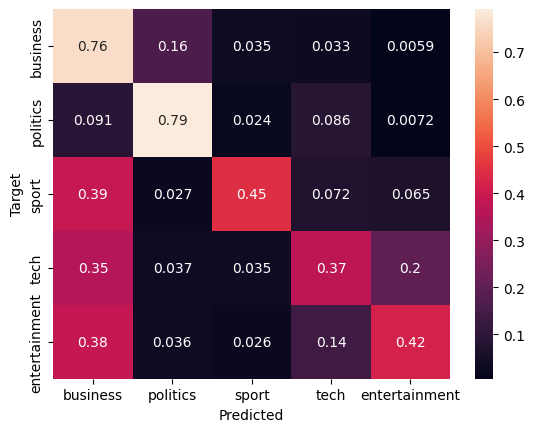

In [ ]:
def plot_cm(cm):
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

In [ ]:
f1_score(df["labels"], predicted_labels, average="micro")

0.5649438202247191

In [ ]:
roc_auc_score(int_labels, probs, multi_class = 'ovo')

0.885327200963584